In [1]:
import json
import numpy as np
import torch
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset

class FeaturesDataset(Dataset):
    def __init__(self, features_json_path, mode='train', side_size=None, image_processor=None):
        with open(features_json_path, 'r') as map_file:
            self.map = list(json.load(map_file).items())
        self.mode = mode

        self.side_size = side_size
        self.image_processor = image_processor

    def __len__(self):
        return len(self.map)

    def __getitem__(self, idx):
        image_path, feature_path = self.map[idx]
        feature = torch.load(feature_path, map_location='cpu').to(torch.float32)
        
        image = Image.open(image_path).convert('RGB')
        
        processed_image = self.image_processor(image)['pixel_values'][0]
        processed_image = torch.tensor(processed_image)
        if processed_image.shape[-1] != self.side_size:
            interpolated_image = F.interpolate(processed_image[None], size=(self.side_size, self.side_size), mode='bilinear', align_corners=False)[0]
        else:
            interpolated_image = processed_image
        
        if self.mode == 'train':
            return interpolated_image, feature.permute(2, 0, 1) # tensor[3 x 224 x 224], tensor[768 x 14 x 14]
        else:
            return np.asarray(image), interpolated_image, feature.permute(2, 0, 1) # array(427, 640, 3), tensor[3 x 224 x 224], tensor[768 x 14 x 14]

In [2]:
import os
from transformers import SiglipImageProcessor

side_size=256
vision_model_name = 'google/siglip2-base-patch16-512'
features_json_path = os.path.join(os.getcwd(), f'../generated_datasets/{"-".join(vision_model_name.split("/"))}/map_train.json')
weights_dir = os.path.join(os.getcwd(), '../feature_extractor_weights')

image_processor = SiglipImageProcessor.from_pretrained(vision_model_name, cache_dir=weights_dir)
val_dataset = FeaturesDataset(features_json_path, 'val', side_size, image_processor)
print(len(val_dataset))

/home/jovyan/.mlspace/envs/nips-interpretation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


7


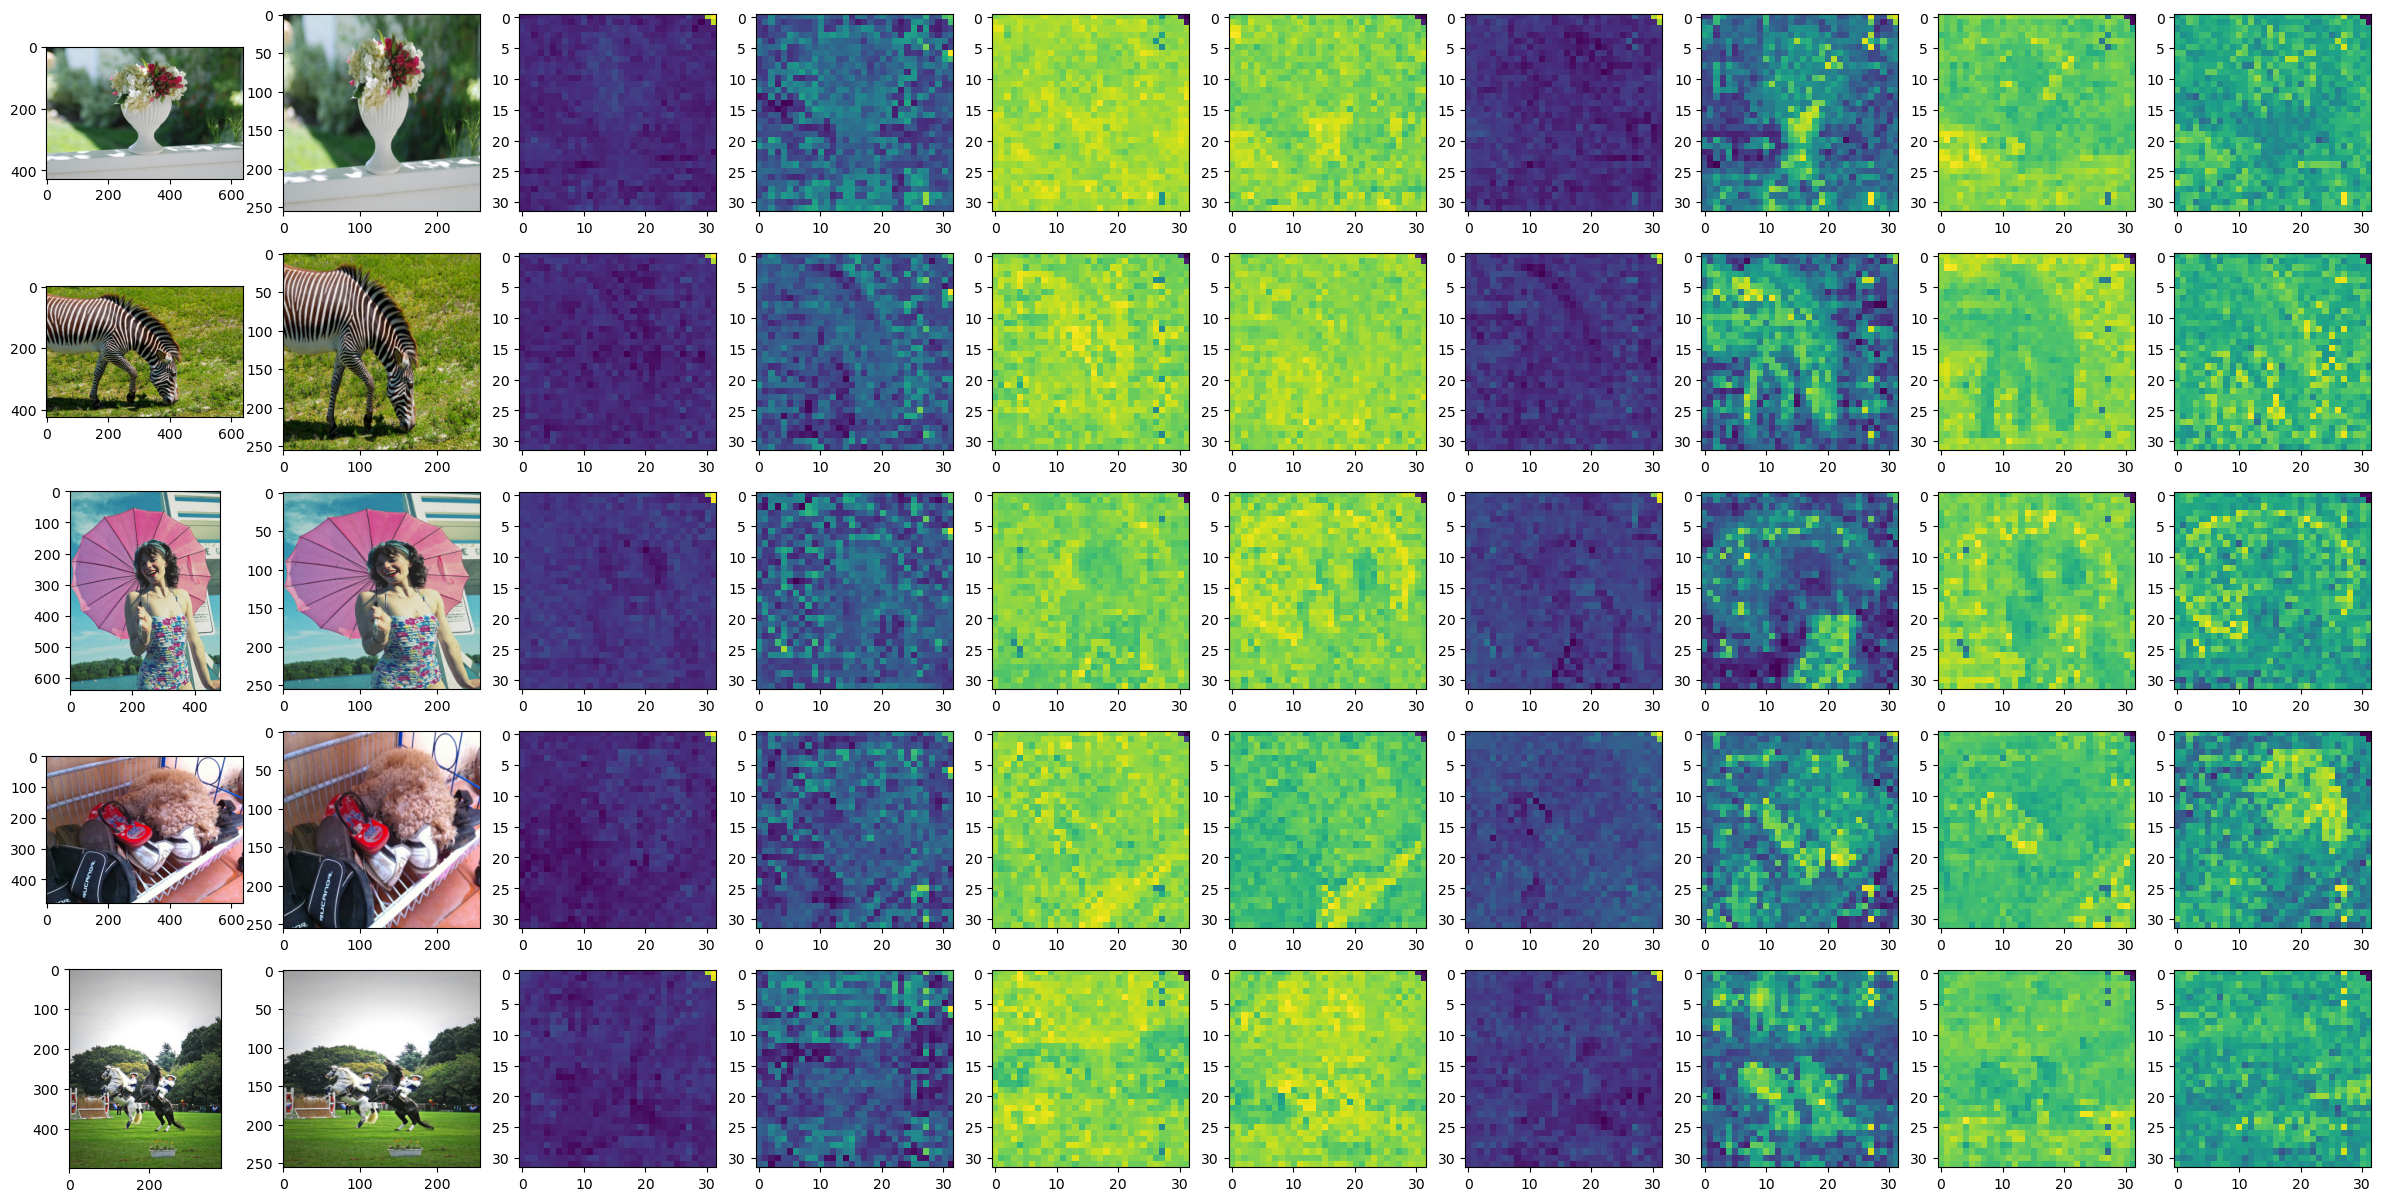

In [3]:
import torch
import matplotlib.pyplot as plt

im_mean = torch.as_tensor(image_processor.image_mean)
im_std = torch.as_tensor(image_processor.image_std)

nrows, ncols, scale = 5, 10, 3
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * scale, nrows * scale))

for i in range(nrows):
    im, inter_im, t = val_dataset[i]
    inter_im = inter_im.permute(1, 2, 0)
    inter_im = inter_im * im_std[None, None] + im_mean[None, None]

    axes[i, 0].imshow(im)
    axes[i, 1].imshow(inter_im)
    for j in range(2, ncols):
        axes[i, j].imshow(t[t.shape[0] // (ncols - 2) * (j - 2)])